# Online system identification in Duffing oscillator by free energy minimisation

This project considers a [Duffing oscillator](https://en.wikipedia.org/wiki/Duffing_equation), a driven damped harmonic oscillator with a cubic nonlinearity in its spring stiffness component. State-space model description of the system:

$$\begin{align}
m \frac{d^2 x(t)}{dt^2} + c \frac{d x(t)}{dt} + a x(t) + b x^3(t) =&\ u(t) + w(t) \\
y(t) =&\ x(t) + e(t)
\end{align}$$

where
$$\begin{align}
m     =&\ \text{mass} \\
c     =&\ \text{damping} \\
a     =&\ \text{linear stiffness} \\
b     =&\ \text{nonlinear stiffness} \\
y(t)    =&\ \text{observation (displacement)} \\
x(t)    =&\ \text{state (displacement)} \\
u(t)    =&\ \text{force} \\
v(t)    =&\ \text{measurement noise} \\
w(t)    =&\ \text{process noise}
\end{align}$$

The process noise is a Wiener process, where the increment is Gaussian distributed $w(t) \sim \mathcal{N}(0, \tau^{-1}dt)$. The parameter $\tau$ represents the precision of the process. The measurement noise is also a Wiener process, $v(t) \sim \mathcal{N}(0, \xi^{-1}dt)$.

## Forecasting experiment: 1-step ahead prediction error

In this notebook, we will perform a forecasting experiment. At each point in time, we will make a prediction for the next observation. That prediction will be evaluated and compared to a few benchmark methods.

### Data

There is an electronic implementation of the Duffing oscillator on the Nonlinear System Identification Benchmark website: http://nonlinearbenchmark.org/#Silverbox. It's called Silverbox.

In [1]:
using Revise
using CSV
using DataFrames

In [2]:
using Plots
viz = false;

In [3]:
# Read data from CSV file
df = CSV.read("data/SNLS80mV.csv", ignoreemptylines=true)
df = select(df, [:V1, :V2])

# Sampling frequency
fs = 610.35

# Shorthand
input = df[:,1]
output = df[:,2]

# Time horizon
T = size(df, 1);

In [4]:
# Select training set
trn = collect(40101:131072)
input_trn = input[trn]
output_trn = output[trn]
T_trn = length(trn);

# Select validation set
val = 101:40100
input_val = input[val]
output_val = output[val]
T_val = length(val);

In [5]:
# Plot every n-th time-point to avoid figure size exploding
n = 50

if viz
    p1a = Plots.plot(1:n:T_trn, input_trn[1:n:end], color="red", label="", markersize=2, xlabel="", ylabel="input", ylims=[-0.25, 0.25], size=(1200,400), title="training")    
    p1b = Plots.plot(1:n:T_trn, output_trn[1:n:end], color="blue", label="", markersize=2, xlabel="time (t)", ylabel="output", ylims=[-0.25, 0.25], size=(1200,400))    
    p1 = plot(p1a, p1b, layout=(2,1))
    Plots.savefig(p1, "figures/training_set.png")
end

In [6]:
if viz
    p2a = Plots.plot(1:n:T_val, input_val[1:n:end], color="red", label="", markersize=2, xlabel="", ylabel="input", ylims=[-0.25, 0.25], size=(1200,400), title="validation")    
    p2b = Plots.plot(1:n:T_val, output_val[1:n:end], color="blue", label="", markersize=2, xlabel="time (t)", ylabel="output", ylims=[-0.25, 0.25], size=(1200,400))    
    p2 = plot(p2a, p2b, layout=(2,1))
    Plots.savefig(p2, "figures/validation_set.png")
end

## Solution steps

### Prediction error minimisation

This is a black-box linear state-space model, of the form:

$$\begin{align}
x' =&\ Ax + Bu + Ke \\
y =&\ Cx + e \, .
\end{align}$$

Inference is performed offline using Least-Squares Minimisation.s

## Implementation

We implemented the above inference procedure using [ControlSystemIdentification.jl](https://github.com/baggepinnen/ControlSystemIdentification.jl), part of the larger [ControlSystems.jl](https://github.com/JuliaControl/ControlSystems.jl) toolbox.

In [7]:
using ControlSystems
using ControlSystemIdentification
using Optim
using Random

In [8]:
# Collect data
data = iddata(output_trn, input_trn)

# Number of poles in the system
nx = 2

# Estimate model
sysh,x0h,opt = pem(data, nx=nx, focus=:prediction);

 * Status: success

 * Candidate solution
    Final objective value:     6.836782e-07

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 1.37e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.18e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.47e-13 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.07e-07 ≰ 0.0e+00
    |g(x)|                 = 6.44e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   36  (vs limit Inf)
    Iterations:    91
    f(x) calls:    342
    ∇f(x) calls:   342



In [9]:
sysh

StateSpaceNoise{Float64,Array{Float64,2}}
A = 
  1.4644985208564698  1.0
 -0.9378929786094234  0.0
B = 
 0.3718370103601042
 0.00797106260995294
C = 
 1.0  0.0
D = 
 0.0

Sample Time: 1.0 (seconds)
Discrete-time state-space model

In [10]:
# Predict using estimated model
yh = predict(sysh, iddata(output_val, input_val), x0h)
predictions = [yh[n][1] for n = 1:length(yh)];

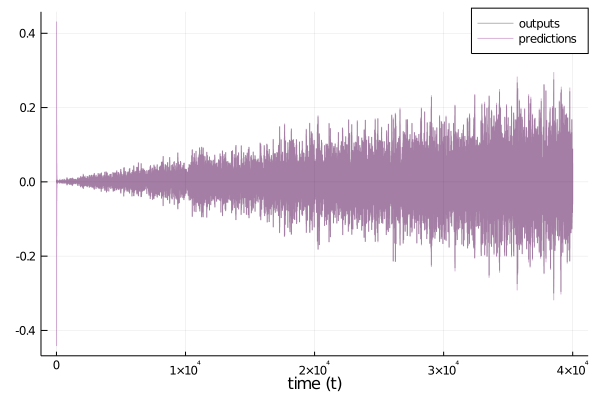

In [11]:
# Plot prediction and true output
plot(output_val, color="black", label="outputs", alpha=0.3)
plot!(predictions, color="purple", label="predictions", xlabel="time (t)", alpha=0.3)

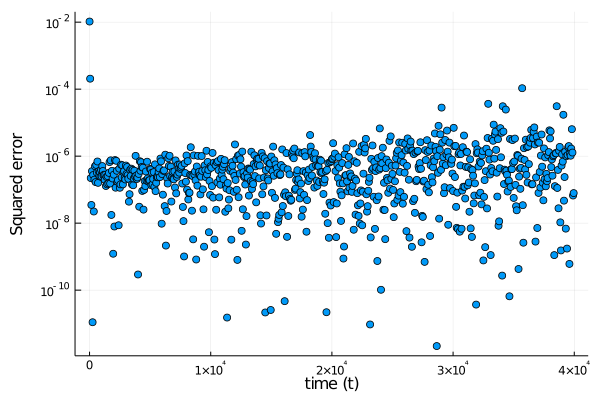

In [15]:
# Compute prediction error
pred_error = (predictions - output_val).^2

# Subsample for visualization
ss = 50
viz_ix = 1:ss:40000

# Scatter error over time
scatter(viz_ix, pred_error[viz_ix], yscale=:log10, label="", xlabel="time (t)", ylabel="Squared error")